FCPG Tools (v2) Test Notebooks
===============================

In [1]:
# import non-fcpgtools dependencies
import xarray as xr
import geopandas as gpd
import numpy as np
import pydaymet
from pathlib import Path
from importlib import reload

In [2]:
# import fcpgtools using conda-develop
!conda-develop C:\\Users\\xrnogueira\\Documents\\FCPGtools\\src
import fcpgtools
from fcpgtools import tools, utilities, terrainengine

path exists, skipping C:\Users\xrnogueira\Documents\FCPGtools\src
completed operation for: C:\Users\xrnogueira\Documents\FCPGtools\src


In [3]:
# get all necessary paths for in/out data
examples_dir = str(Path.cwd())
if 'FCPGtools' in examples_dir:
    examples_dir = Path(examples_dir.split('FCPGtools', 2)[0] + 'FCPGtools\\examples')
    print(f'var:examples_dir = {examples_dir}')
else:
    del examples_dir
    print('ERROR: Cant find /FCPGtools/examples!')

var:examples_dir = C:\Users\xrnogueira\Documents\FCPGtools\examples


In [4]:
# get all necessary paths for in/out data
in_data_dir = examples_dir / Path('in_data')
print(f'Variable in_data_dir accesses {in_data_dir}')
out_data_dir = examples_dir / Path('out_data')
print(f'Variable in_data_dir accesses {out_data_dir}')

Variable in_data_dir accesses C:\Users\xrnogueira\Documents\FCPGtools\examples\in_data
Variable in_data_dir accesses C:\Users\xrnogueira\Documents\FCPGtools\examples\out_data


# Import Data
**Local files:**
* `us_fdr`: upstream basin Flow Direction Raster (ESRI format).
* `ds_fdr`: downstream basin Flow Direction Raster (ESRI format).
* `daymet_single`: a annual averaged DAYMET precipitation raster.
* `landcover`: a NALCMS 2015 land cover categorical raster.
* `basins_shp`: a shapefile where each row corresponds to a HUC12 level basin.

**Remote files:**
* `daymet_multi`: a 2021 monthly averaged DAYMET precipitation raster accessed via `pydaymet`.

## Pull in local test data

### Get local raster files as `xr.DataArray`s 
**Note:** While seemingly redundant, using `pathlib.Path` objects improves application security, especially if deployed on a remote server. This is because string paths are passed into TauDEM command line calls, which opens a vunerability to custom strings that could control a server remotely. Assuring that all inputs are valid paths (therefore not arbitrary malicious strings), protects against this.

In [5]:
# get tif data paths
us_fdr_tif = in_data_dir / Path('validation_upstream_fdr.tif')
ds_fdr_tif = in_data_dir / Path('validation_downstream_fdr.tif')
landcover_tif = in_data_dir / Path('NALCMS_2015.tif')
daymet_tif = in_data_dir / Path('validation_daymet_an_P_2017.tif')

# get upstream basin shapefile path
us_basin_shp_path = in_data_dir / Path('upstream_wbd.shp')

In [6]:
us_fdr = utilities.load_raster(us_fdr_tif)
ds_fdr = utilities.load_raster(ds_fdr_tif)
landcover = utilities.load_raster(landcover_tif)
daymet_single = utilities.load_raster(daymet_tif)

### Get the basin shapefiles as `geopandas.GeoDataFrame` objects

In [7]:
us_basin_shp = utilities.load_shapefile(us_basin_shp_path)
us_basin_shp

OBJECTID                                   TNMID  \
0      2685  {AAAE4745-7F69-4249-9EE6-61A0FDD375D2}   
1      2737  {6ECBF3AC-20C7-4EA3-AF3A-F8DB61EF2BBB}   

                               MetaSource SourceData SourceOrig SourceFeat  \
0  {2E2678AC-0C9D-49CB-806B-540A9302D247}       None       None       None   
1  {AEC557FF-82D8-4F4D-BF0D-2BF431714390}       None       None       None   

     LoadDate  NonContrib  NonContr_1  AreaSqKm  ...  GNIS_ID  \
0  2013-01-18         0.0         0.0    133.04  ...        0   
1  2017-10-25         0.0         0.0     90.55  ...        0   

                        Name States         HUC12 HUType HUMod         ToHUC  \
0  Honey Draw-Colorado River     AZ  140700061105      S    DM  150100010303   
1  Johnson Point-Paria River  AZ,UT  140700070706      S    NM  150100010303   

  Shape_Leng  Shape_Area                                           geometry  
0   0.805006    0.013444  POLYGON ((-111.45208 36.90750, -111.45209 36.9...  
1   0.612730    0.009157  POLYGON ((-111.69386 37.00586, -111.69386 37.0...  

[2 rows x 21 columns]

In [8]:
us_basin_shp.columns

Index(['OBJECTID', 'TNMID', 'MetaSource', 'SourceData', 'SourceOrig',
       'SourceFeat', 'LoadDate', 'NonContrib', 'NonContr_1', 'AreaSqKm',
       'AreaAcres', 'GNIS_ID', 'Name', 'States', 'HUC12', 'HUType', 'HUMod',
       'ToHUC', 'Shape_Leng', 'Shape_Area', 'geometry'],
      dtype='object')

## Import a 12 month DAYMET precipitation raster from `pydaymet` using our AOI
**Note:** Here we use [`pydaymet`](https://hyriver.readthedocs.io/en/latest/autoapi/pydaymet/pydaymet/index.html) to read Daymet data directly into a `xr.DataSet`. We then query only for precipitation (`variable='prcp')` to get a `xr.DataArray`.

In [9]:
bounding_box = list(tools.reproject_raster(daymet_single, us_basin_shp).rio.bounds())
bounding_box

[-111.78588315084252,
 36.72363635079582,
 -111.38205939972336,
 37.05106101386543]

In [10]:
%%time
daymet_multi = pydaymet.get_bygeom(bounding_box,
    crs=us_basin_shp.crs.to_wkt(),
    dates=("2021-01-01", "2021-12-30"),
    variables='prcp',
    time_scale="monthly",
    )['prcp']
daymet_multi

CPU times: total: 1.39 s
Wall time: 2.01 s


<xarray.DataArray 'prcp' (time: 12, y: 39, x: 39)>
dask.array<getitem, shape=(12, 39, 39), dtype=float32, chunksize=(12, 39, 39), chunktype=numpy.ndarray>
Coordinates:
  * time                     (time) datetime64[ns] 2021-01-16T12:00:00 ... 20...
  * y                        (y) float32 -508.0 -509.0 -510.0 ... -545.0 -546.0
  * x                        (x) float32 -1.006e+03 -1.005e+03 ... -969.2 -968.2
    lambert_conformal_conic  int32 0
Attributes:
    cell_methods:  area: mean time: sum within days time: sum over days
    units:         mm
    long_name:     monthly total precipitation
    _ChunkSizes:   [ 10 300 300]

# Convert ESRI FDR to TauDEM FDR

In [11]:
# display the dicts sotring D8 formats
print('D8 Formats supported by FCPGtools:')
display(fcpgtools.custom_types.D8ConversionDicts)

D8 Formats supported by FCPGtools:


{'taudem': {'southeast': 8,
  'south': 7,
  'southwest': 6,
  'west': 5,
  'northwest': 4,
  'north': 3,
  'northeast': 2,
  'east': 1,
  'nodata': 0},
 'esri': {'southeast': 2,
  'south': 4,
  'southwest': 8,
  'west': 16,
  'northwest': 32,
  'north': 64,
  'northeast': 128,
  'east': 1,
  'nodata': 255}}

In [12]:
%%time
# make a taudem FDR
us_fdr_taudem = tools.convert_fdr_formats(
        us_fdr,
        out_format='TAUDEM',
        in_format=None,
        )

Converted the D8 Flow Direction Raster (FDR) from esri format to taudem
CPU times: total: 125 ms
Wall time: 134 ms


TauDEM format ustream basin FDR


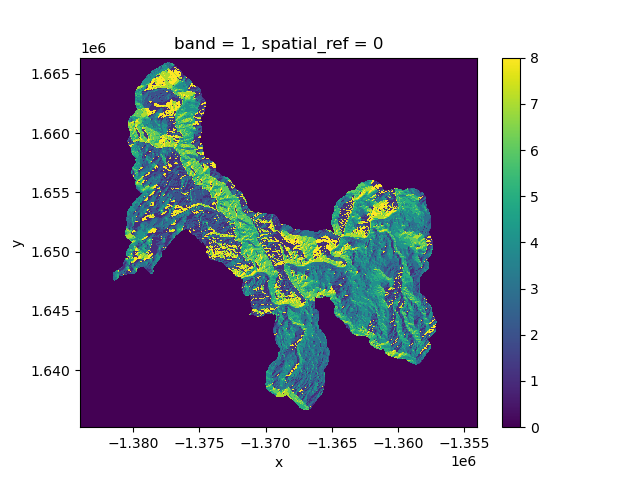

In [13]:
%matplotlib widget
print('TauDEM format ustream basin FDR')
us_fdr_taudem.plot()

In [14]:
print(f'TauDEM nodata value: {us_fdr_taudem.rio.nodata}')

TauDEM nodata value: 0


In [15]:
%%time
# test back-conversion by re-making the esri format FDR
us_fdr_esri = tools.convert_fdr_formats(
        us_fdr_taudem,
        out_format='esri',
        in_format=None,
        )

Converted the D8 Flow Direction Raster (FDR) from taudem format to esri
CPU times: total: 109 ms
Wall time: 112 ms


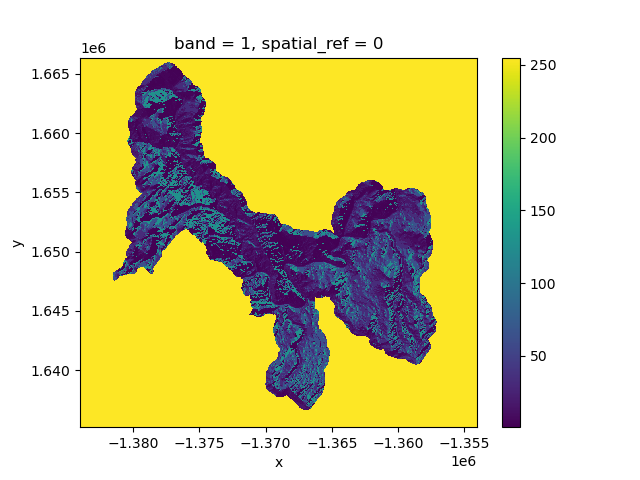

In [16]:
%matplotlib widget
us_fdr_esri.plot()

In [17]:
print(f'ESRI nodata value: {us_fdr_esri.rio.nodata}')

ESRI nodata value: 255


# Prep Parameter Grids

## Resample/reproject/clip Daymet data

In [18]:
us_fdr_crs = us_fdr.rio.crs
us_fdr_crs

CRS.from_wkt('PROJCS["NAD_1983_Albers",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [19]:
%%time
print('Aligning single band daymet data to us_fdr:')
aligned_daymet_single = tools.align_raster(
    daymet_single,
    us_fdr,
    resample_method='bilinear',
    )

Aligning single band daymet data to us_fdr:
CPU times: total: 234 ms
Wall time: 234 ms


In [20]:
# verify alignment
utilities._verify_alignment(aligned_daymet_single, us_fdr)

True

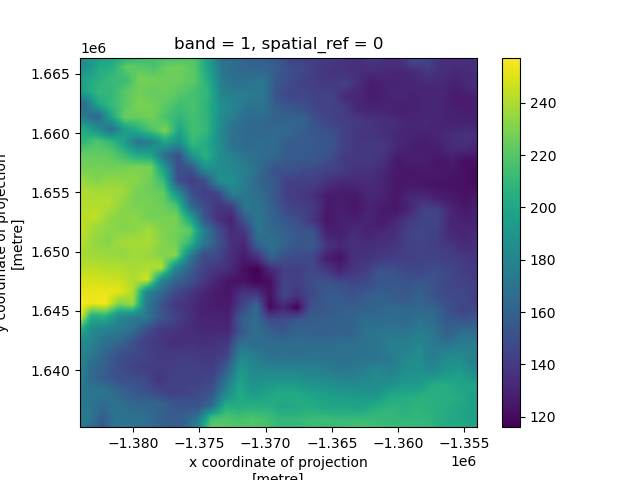

In [21]:
%matplotlib widget
aligned_daymet_single.plot()

Aligning multi-band daymet data to us_fdr (plotting march):


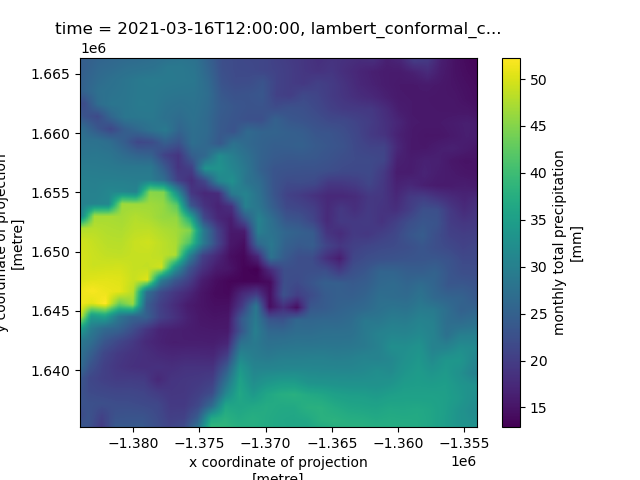

In [22]:
%matplotlib widget
print('Aligning multi-band daymet data to us_fdr (plotting march):')
aligned_daymet_multi = tools.align_raster(
    daymet_multi,
    us_fdr,
    resample_method='bilinear',
    )
aligned_daymet_multi.isel(time=2).plot()

In [23]:
# verify alignment
utilities._verify_alignment(aligned_daymet_multi, us_fdr)

True

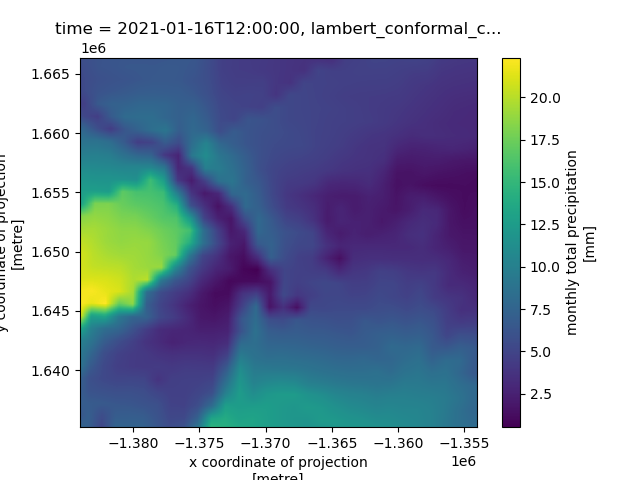

In [24]:
%matplotlib widget
aligned_daymet_multi[0].plot()

## Align and Binarize Land Cover

In [25]:
# make a dictionary to improve land cover class labeling
landcover_classes = {
    1: 'evergreen forest',
    7: 'tropical shrubland',
    8: 'temperate shrubland',
    9: 'tropical grassland',
    10: 'temperate grassland',
    14: 'wetland',
    15: 'cropland',
    16: 'barren',
    17: 'urban',
    18: 'open water',
    }

In [26]:
print(f'Landcover class values: {np.unique(landcover.values)}')

Landcover class values: [ 1  7  8  9 10 14 15 16 17 18]


In [27]:
aligned_landcover = tools.align_raster(
    landcover,
    us_fdr,
    resample_method='nearest',
    )

In [28]:
# verify alignment
utilities._verify_alignment(aligned_landcover, us_fdr)

True

In [29]:
binary_landcover = tools.binarize_categorical_raster(
    cat_raster=aligned_landcover,
    categories_dict=landcover_classes,
    ignore_categories=[18],
    )
print(f'binary_landcover band labels: {binary_landcover[binary_landcover.dims[0]].values}')
binary_landcover

binary_landcover band labels: ['evergreen forest' 'tropical shrubland' 'temperate shrubland'
 'tropical grassland' 'temperate grassland' 'wetland' 'cropland' 'barren'
 'urban' 255]


<xarray.DataArray (band: 10, y: 1039, x: 998)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]]], dtype=uint8)
Coordinates:
  * x            (x) float64 -1.384e+06 -1.384e+06 ... -1.354e+06 -1.354e+06
  * y            (y) float64 1.666e+06 1.666e+06 ... 1.635e+06 1.635e+06
  * band         (band) object 'evergreen forest' 'tropical shrubland' ... 255
    spatial_ref  int32 0
Attributes:
    RepresentationType:      THEMATIC
    STATISTICS_MAXIMUM:      18
    STATISTICS_MEAN:         8.6976529407961
    STATISTICS_MINIMUM:      1
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       2.4539097667876
    scale_factor:            1.0
    add_offset:              0.0
    _FillValue:              255

In [30]:
binary_landcover.dtype

dtype('uint8')

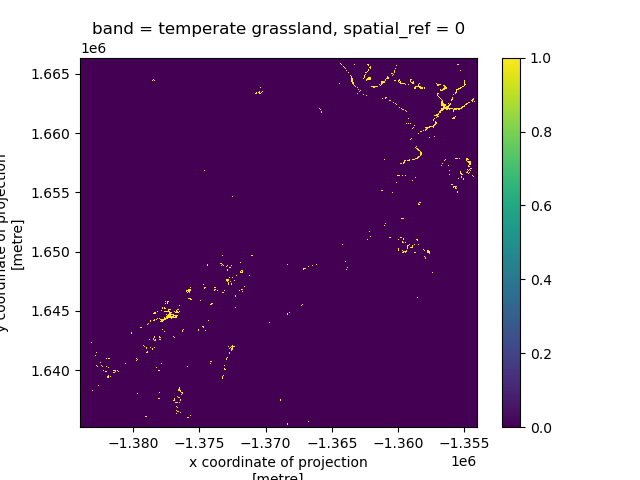

In [31]:
%matplotlib widget
binary_landcover[4].plot()

# Make Upstream Basin Flow Accumulation Cell (FAC) Rasters

## w/ PySheds

In [32]:
%%time
fac_pysheds = terrainengine.pysheds_engine.accumulate_flow(
    d8_fdr=us_fdr_esri,
    upstream_pour_points=None,
    )
print(f'PySheds FAC nodata value: {fac_pysheds.rio.nodata}')

PySheds FAC nodata value: nan
CPU times: total: 203 ms
Wall time: 207 ms


In [33]:
print(fac_pysheds.dtype)
fac_pysheds

float64


<xarray.DataArray 'accumulate' (y: 1039, x: 998)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    band         int32 1
  * x            (x) float64 -1.384e+06 -1.384e+06 ... -1.354e+06 -1.354e+06
  * y            (y) float64 1.666e+06 1.666e+06 ... 1.635e+06 1.635e+06
    spatial_ref  int32 0
Attributes:
    BandName:                fdr
    RepresentationType:      ATHEMATIC
    STATISTICS_COVARIANCES:  1837.432364428409
    STATISTICS_MAXIMUM:      128
    STATISTICS_MEAN:         39.559092546377
    STATISTICS_MINIMUM:      1
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       42.865281574118
    _FillValue:              nan
    scale_factor:            1.0
    add_offset:              0.0

C:\Users\xrnogueira\Miniconda3\envs\fcpgtools\lib\site-packages\xarray\core\computation.py:771: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


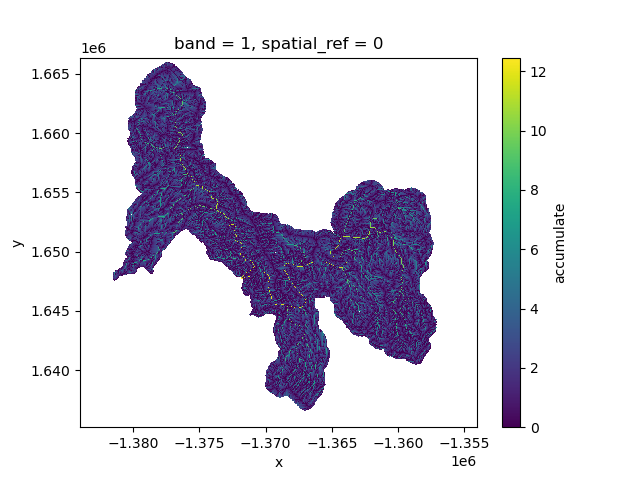

In [34]:
%matplotlib widget
np.log(fac_pysheds).plot()

In [35]:
fac_pysheds

<xarray.DataArray 'accumulate' (y: 1039, x: 998)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    band         int32 1
  * x            (x) float64 -1.384e+06 -1.384e+06 ... -1.354e+06 -1.354e+06
  * y            (y) float64 1.666e+06 1.666e+06 ... 1.635e+06 1.635e+06
    spatial_ref  int32 0
Attributes:
    BandName:                fdr
    RepresentationType:      ATHEMATIC
    STATISTICS_COVARIANCES:  1837.432364428409
    STATISTICS_MAXIMUM:      128
    STATISTICS_MEAN:         39.559092546377
    STATISTICS_MINIMUM:      1
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       42.865281574118
    _FillValue:              nan
    scale_factor:            1.0
    add_offset:              0.0

## w/ TauDEM

In [36]:
fcpgtools.custom_types.Raster

typing.Union[xarray.core.dataarray.DataArray, str, pathlib.Path]

In [37]:
%%time
fac_taudem = terrainengine.taudem_engine.accumulate_flow(
    d8_fdr=us_fdr_taudem,
    upstream_pour_points=None,
    )
print(f'PySheds FAC nodata value: {fac_taudem.rio.nodata}')

PySheds FAC nodata value: nan
CPU times: total: 125 ms
Wall time: 468 ms


In [38]:
print(fac_taudem.dtype)
fac_taudem

float64


<xarray.DataArray (y: 1039, x: 998)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    band         int32 1
  * x            (x) float64 -1.384e+06 -1.384e+06 ... -1.354e+06 -1.354e+06
  * y            (y) float64 1.666e+06 1.666e+06 ... 1.635e+06 1.635e+06
    spatial_ref  int32 0
Attributes:
    _FillValue:    nan
    scale_factor:  1.0
    add_offset:    0.0

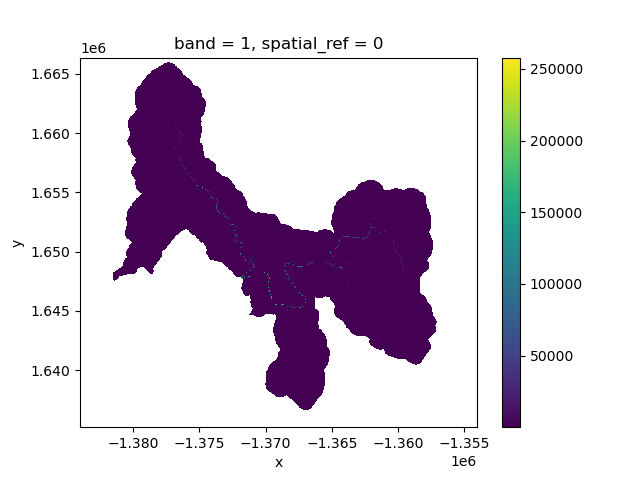

In [39]:
%matplotlib widget
fac_taudem.plot()

# Get HUC basin pour point locations and accumulation values
`tools.get_pour_point_values()` -> `custom_types.PourPointValuesDict`, which has the following form:
```python
# index positions in each dict.values() list corresponds to the basin ID
pour_point_values_dict = {
    'pour_point_ids': ['140700061105', '140700070706'], # each basin ID
    'pour_point_coords': [(-1370609.9, 1648259.9), (-1375289.9, 1653809.9)], # x, y coordinates of each basin's pour point
    'pour_point_values': [[32738.0], [8721.0]] # the value at the pour point -> will have multiple values for a multi-band paramaeter accumulation
}
```

## HUC12 basin

In [40]:
%%time
huc12_pour_points_loc = tools.find_basin_pour_points(
            fac_pysheds,
            us_basin_shp,
            basin_id_field='HUC12',
            use_huc4=False,
            )

huc12_pour_point_values_dict = tools.get_pour_point_values(
            huc12_pour_points_loc,
            fac_pysheds,
            )
display(huc12_pour_point_values_dict)

{'pour_point_ids': ['140700061105', '140700070706'],
 'pour_point_coords': [(-1370639.9999999995, 1648259.9999999963),
  (-1371809.9999999995, 1647809.9999999963)],
 'pour_point_values': [[155004.0], [101306.0]]}

CPU times: total: 609 ms
Wall time: 611 ms


## HUC4 basin

In [41]:
%%time
huc4_pour_points_loc = tools.find_basin_pour_points(
            fac_pysheds,
            us_basin_shp,
            basin_id_field='HUC12',
            use_huc4=True,
            )

huc4_pour_point_values_dict = tools.get_pour_point_values(
            huc4_pour_points_loc,
            fac_pysheds,
            )
display(huc4_pour_point_values_dict)

Using HUC4 level flow basins, converting from HUC12


{'pour_point_ids': ['1407'],
 'pour_point_coords': [(-1370639.9999999995, 1648259.9999999963)],
 'pour_point_values': [[155004.0]]}

CPU times: total: 391 ms
Wall time: 380 ms


# Make Daymet parameter accumulation grid

## w/ PySheds

### Annual averaged (single-band)

In [42]:
%%time
daymet_single_accum = terrainengine.pysheds_engine.accumulate_parameter( 
    d8_fdr=us_fdr_esri,
    parameter_raster=aligned_daymet_single,
    )
daymet_single_accum

CPU times: total: 344 ms
Wall time: 348 ms


<xarray.DataArray 'accumulate' (y: 1039, x: 998)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    band         int32 1
  * x            (x) float64 -1.384e+06 -1.384e+06 ... -1.354e+06 -1.354e+06
  * y            (y) float64 1.666e+06 1.666e+06 ... 1.635e+06 1.635e+06
    spatial_ref  int32 0
Attributes:
    BandName:                fdr
    RepresentationType:      ATHEMATIC
    STATISTICS_COVARIANCES:  1837.432364428409
    STATISTICS_MAXIMUM:      128
    STATISTICS_MEAN:         39.559092546377
    STATISTICS_MINIMUM:      1
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       42.865281574118
    _FillValue:              nan
    scale_factor:            1.0
    add_offset:              0.0

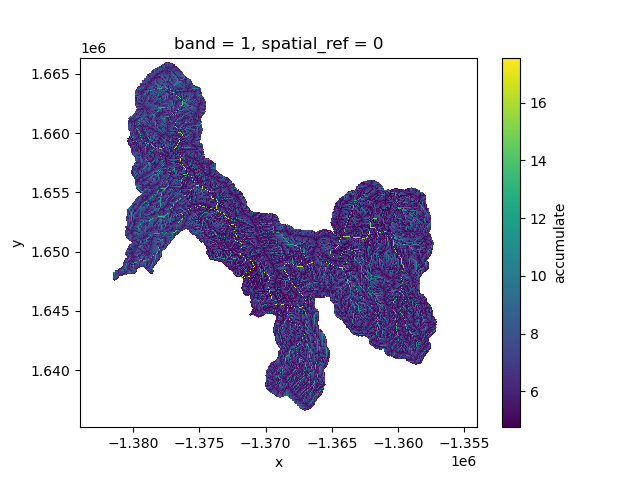

In [43]:
%matplotlib widget
np.log(daymet_single_accum).plot()

### Monthly averaged (multi-band)

In [44]:
%%time
daymet_multi_accum = terrainengine.pysheds_engine.accumulate_parameter( 
    d8_fdr=us_fdr_esri,
    parameter_raster=aligned_daymet_multi,
    )
daymet_multi_accum

CPU times: total: 4.31 s
Wall time: 3.92 s


<xarray.DataArray 'accumulate' (time: 12, y: 1039, x: 998)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
    band         int32 1
  * x            (x) float64 -1.384e+06 -1.384e+06 ... -1.354e+06 -1.354e+06
  * y            (y) float64 1.666e+06 1.666e+06 ... 1.635e+06 1.635e+06
    spatial_ref  int32 0
  * time         (time) datetime64[ns] 2021-01-16T12:00:00 ... 2021-12-16T12:...
Attributes:
    BandName:                fdr
    RepresentationType:      ATHEMATIC
    STATISTICS_COVARIANCES:  1837.432364428409
    STATISTICS_MAXIMUM:      128
    STATISTICS_MEAN:         39.559092546377
    STATISTICS_MINIMUM:      1
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       42.865281574118
    _FillValue:              nan
    scale_factor:            1.0
    add_offset:              0.0

In [45]:
for band in range(len(daymet_multi_accum[daymet_multi_accum.dims[0]])):
    print(f'Mean month={band + 1} accumulation: {daymet_multi_accum[band].mean()}')

Mean month=1 accumulation: 2639.152972650387
Mean month=2 accumulation: 2821.2553783872286
Mean month=3 accumulation: 11260.538613576053
Mean month=4 accumulation: 2521.58989444457
Mean month=5 accumulation: 0.0
Mean month=6 accumulation: 1121.066833217714
Mean month=7 accumulation: 15669.60532163561
Mean month=8 accumulation: 6346.868701639916
Mean month=9 accumulation: 6736.363583481212
Mean month=10 accumulation: 15784.973802478664
Mean month=11 accumulation: 0.0
Mean month=12 accumulation: 8059.959134195021


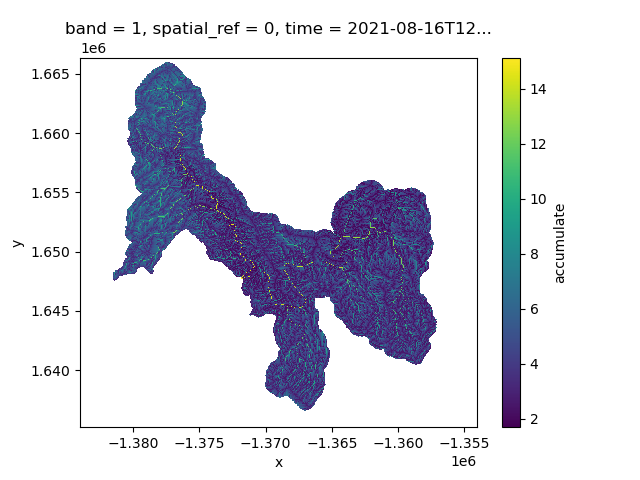

In [46]:
%matplotlib widget
np.log(daymet_multi_accum[7]).plot()

## w/ TauDEM

### Annual averaged (single-band)

In [47]:
%%time
daymet_single_accum_taudem = terrainengine.taudem_engine.accumulate_parameter( 
    d8_fdr=us_fdr_taudem,
    parameter_raster=aligned_daymet_single,
    )
daymet_single_accum_taudem

CPU times: total: 250 ms
Wall time: 567 ms


<xarray.DataArray 'accumulate_parameter' (y: 1039, x: 998)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    band         int32 1
  * x            (x) float64 -1.384e+06 -1.384e+06 ... -1.354e+06 -1.354e+06
  * y            (y) float64 1.666e+06 1.666e+06 ... 1.635e+06 1.635e+06
    spatial_ref  int32 0
Attributes:
    _FillValue:    nan
    scale_factor:  1.0
    add_offset:    0.0

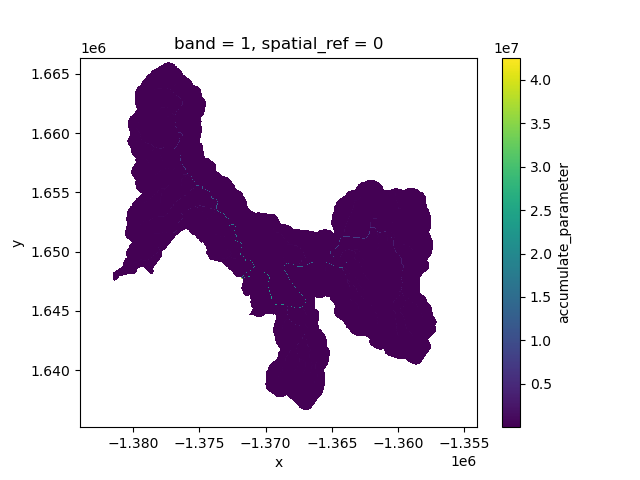

In [48]:
%matplotlib widget
daymet_single_accum_taudem.plot()

### Monthly averaged (multi-band)

In [49]:
%%time
daymet_multi_accum_taudem = terrainengine.taudem_engine.accumulate_parameter( 
    d8_fdr=us_fdr_taudem,
    parameter_raster=aligned_daymet_multi,
    )
daymet_multi_accum_taudem

CPU times: total: 2.39 s
Wall time: 6.3 s


<xarray.DataArray 'accumulate_parameter' (time: 12, y: 1039, x: 998)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
    band         int32 1
  * x            (x) float64 -1.384e+06 -1.384e+06 ... -1.354e+06 -1.354e+06
  * y            (y) float64 1.666e+06 1.666e+06 ... 1.635e+06 1.635e+06
    spatial_ref  int32 0
  * time         (time) datetime64[ns] 2021-01-16T12:00:00 ... 2021-12-16T12:...
Attributes:
    _FillValue:    nan
    scale_factor:  1.0
    add_offset:    0.0

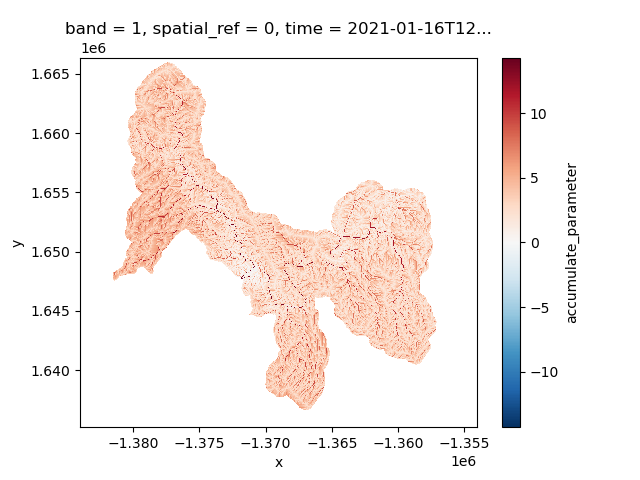

In [50]:
%matplotlib widget
np.log(daymet_multi_accum_taudem[0]).plot()

In [51]:
# note that in the raw data months 5 and 11 are all zeros so should be zero
for band in range(len(daymet_multi_accum_taudem[daymet_multi_accum_taudem.dims[0]])):
    print(f'Mean month={band + 1} accumulation: {daymet_multi_accum_taudem[band].mean()}')

Mean month=1 accumulation: 2645.992449013559
Mean month=2 accumulation: 2828.9382906978317
Mean month=3 accumulation: 11295.7735548258
Mean month=4 accumulation: 2528.324296117884
Mean month=5 accumulation: 0.0
Mean month=6 accumulation: 1123.2729159875234
Mean month=7 accumulation: 15719.42432541742
Mean month=8 accumulation: 6365.742194532159
Mean month=9 accumulation: 6756.6588387722695
Mean month=10 accumulation: 15834.161976312449
Mean month=11 accumulation: 0.0
Mean month=12 accumulation: 8084.062358192565


# Make landcover accumulation raster

## w/ PySheds

In [52]:
%%time
landcover_accum_pysheds = terrainengine.pysheds_engine.accumulate_parameter( 
    d8_fdr=us_fdr_esri,
    parameter_raster=binary_landcover,
    )
landcover_accum_pysheds

CPU times: total: 3.61 s
Wall time: 3.32 s


<xarray.DataArray 'accumulate' (band: 10, y: 1039, x: 998)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * band         (band) object 'evergreen forest' 'tropical shrubland' ... 255
  * x            (x) float64 -1.384e+06 -1.384e+06 ... -1.354e+06 -1.354e+06
  * y            (y) float64 1.666e+06 1.666e+06 ... 1.635e+06 1.635e+06
    spatial_ref  int32 0
Attributes:
    BandName:                fdr
    RepresentationType:      ATHEMATIC
    STATISTICS_COVARIANCES:  1837.432364428409
    STATISTICS_MAXIMUM:      128
    STATISTICS_MEAN:         39.559092546377
    STATISTICS_MINIMUM:      1
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       42.865281574118
    _FillValue:              nan
    scale_factor:            1.0
    add_offset:              0.0

C:\Users\xrnogueira\Miniconda3\envs\fcpgtools\lib\site-packages\xarray\core\computation.py:771: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


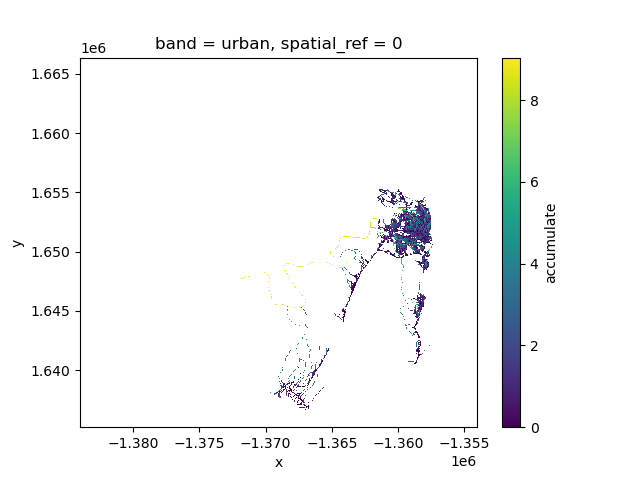

In [53]:
%matplotlib widget
np.log(landcover_accum_pysheds[8]).plot()

In [54]:
for band in list(landcover_accum_pysheds[landcover_accum_pysheds.dims[0]]):
    print(f'Landcover class={band} accumulation: {landcover_accum_pysheds.sel(band=band).mean()}')

Landcover class=evergreen forest accumulation: 0.12929587248904925
Landcover class=tropical shrubland accumulation: 0.0
Landcover class=temperate shrubland accumulation: 391.7038058343117
Landcover class=tropical grassland accumulation: 0.0
Landcover class=temperate grassland accumulation: 1.3606565812493567
Landcover class=wetland accumulation: 2.2235904791615075
Landcover class=cropland accumulation: 0.10406609699070873
Landcover class=barren accumulation: 4.071375285378951
Landcover class=urban accumulation: 21.68534514628493
Landcover class=255 accumulation: 0.0


## w/ TauDEM

In [55]:
%%time
landcover_accum_taudem = terrainengine.taudem_engine.accumulate_parameter( 
    d8_fdr=us_fdr_taudem,
    parameter_raster=binary_landcover,
    )
landcover_accum_taudem

CPU times: total: 1.48 s
Wall time: 4.79 s


<xarray.DataArray 'accumulate_parameter' (band: 10, y: 1039, x: 998)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * band         (band) object 'evergreen forest' 'tropical shrubland' ... 255
  * x            (x) float64 -1.384e+06 -1.384e+06 ... -1.354e+06 -1.354e+06
  * y            (y) float64 1.666e+06 1.666e+06 ... 1.635e+06 1.635e+06
    spatial_ref  int32 0
Attributes:
    _FillValue:    nan
    scale_factor:  1.0
    add_offset:    0.0

In [56]:
for band in range(len(landcover_accum_taudem[landcover_accum_taudem.dims[0]])):
    print(f'Mean landcover class={band + 1} accumulation: {landcover_accum_taudem[band].mean()}')

Mean landcover class=1 accumulation: 0.12734453392337974
Mean landcover class=2 accumulation: 0.0
Mean landcover class=3 accumulation: 391.50216443255204
Mean landcover class=4 accumulation: 0.0
Mean landcover class=5 accumulation: 1.3513552628193584
Mean landcover class=6 accumulation: 2.2160412432140375
Mean landcover class=7 accumulation: 0.10311768338178919
Mean landcover class=8 accumulation: 4.018383204260684
Mean landcover class=9 accumulation: 21.548739933619782
Mean landcover class=10 accumulation: 0.0


# Create basic FCPGs

In [57]:
%%time
fcpg = tools.make_fcpg(daymet_multi_accum_taudem, fac_taudem)

CPU times: total: 46.9 ms
Wall time: 33.5 ms


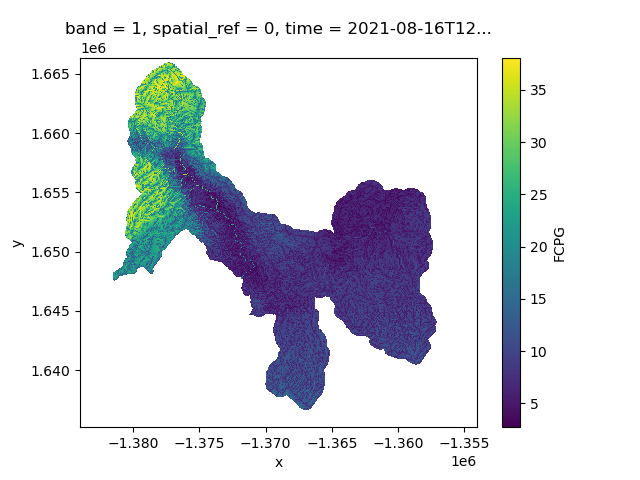

In [58]:
%matplotlib widget
fcpg[7].plot()

In [59]:
# note that in the raw data months 5 and 11 are all zeros so should be zero
for band in range(len(fcpg[fcpg.dims[0]])):
    print(f'Mean month={band + 1} fcpg value: {fcpg[band].mean()}')

Mean month=1 fcpg value: 5.119211380288302
Mean month=2 fcpg value: 5.1366368549554835
Mean month=3 fcpg value: 20.489229505195055
Mean month=4 fcpg value: 4.550452101359355
Mean month=5 fcpg value: 0.0
Mean month=6 fcpg value: 2.028702680886117
Mean month=7 fcpg value: 28.191953896224042
Mean month=8 fcpg value: 11.936423799756797
Mean month=9 fcpg value: 12.318999744693828
Mean month=10 fcpg value: 28.987657448736
Mean month=11 fcpg value: 0.0
Mean month=12 fcpg value: 15.218344766282003


# Make extream upslope value raster (TauDEM only)

In [60]:
%%time
ext_upslope_raster = terrainengine.taudem_engine.extreme_upslope_values(
    d8_fdr=us_fdr_taudem,
    parameter_raster=aligned_daymet_multi,
    mask_streams=None,
    get_min_upslope=False,
    )

CPU times: total: 1.53 s
Wall time: 5.75 s


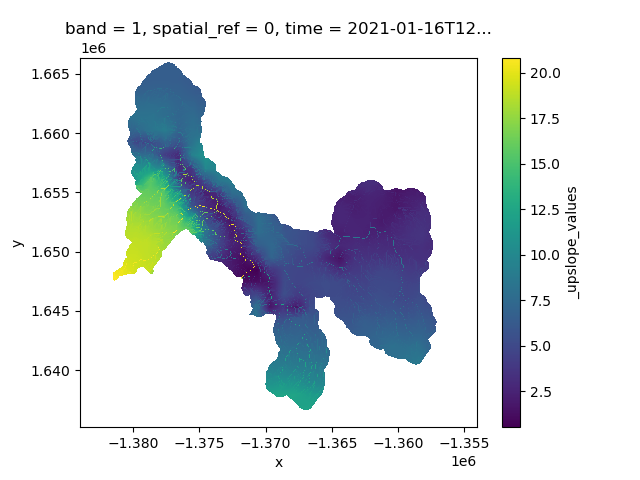

In [61]:
%matplotlib widget
ext_upslope_raster[0].plot()

# Make distance to stream raster (TauDEM only)

In [62]:
dis2stream = terrainengine.taudem_engine.distance_to_stream(
    us_fdr_taudem,
    fac_taudem,
    accum_threshold=500,
    )

C:\Users\xrnogueira\Miniconda3\envs\fcpgtools\lib\site-packages\xarray\core\computation.py:771: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


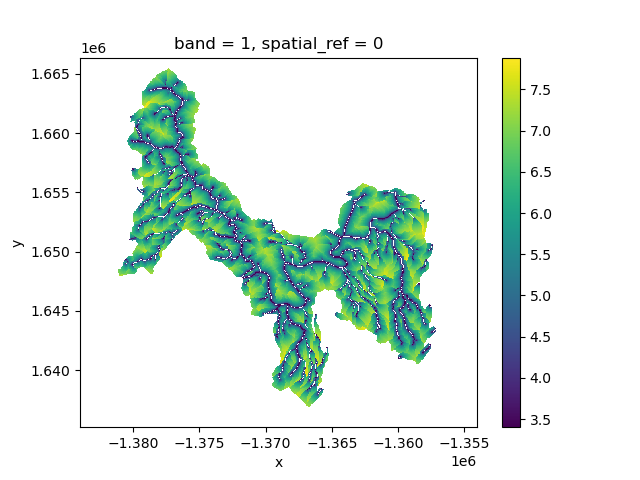

In [63]:
%matplotlib widget
np.log(dis2stream).plot()

# Make a decay accumulation raster (TauDEM only)

## Make decay raster from the distance to stream raster (decay constant = 2)

In [64]:
%%time
decay_raster = tools.make_decay_raster(
    distance_to_stream_raster=dis2stream,
    decay_factor=2,
    )

CPU times: total: 31.2 ms
Wall time: 26.2 ms


## Use the decay raster to alter precipitation accumulation (TauDEM only)

In [68]:
%%time
decay_accum = terrainengine.taudem_engine.decay_accumulation(
    us_fdr_taudem,
    decay_raster=decay_raster,
    parameter_raster=aligned_daymet_multi,
    )

CPU times: total: 1.98 s
Wall time: 13.3 s


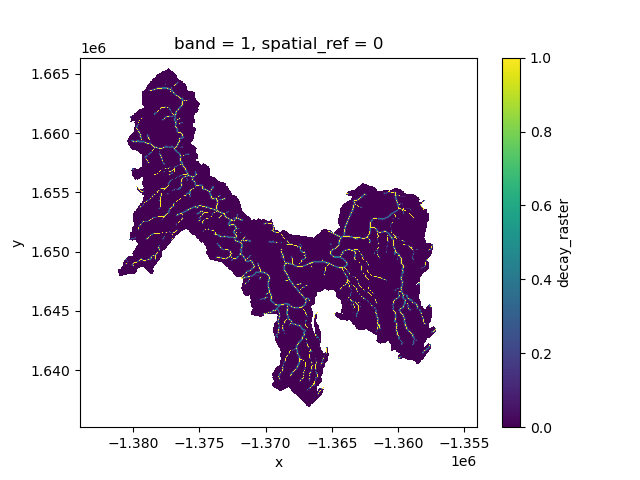

In [69]:
%matplotlib widget
decay_raster.plot()

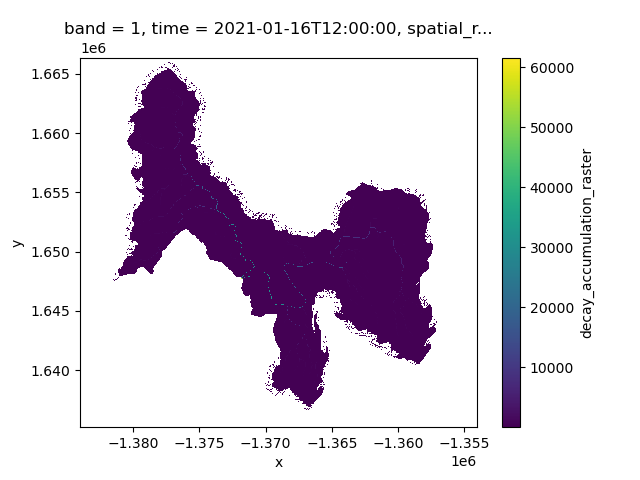

In [70]:
%matplotlib widget
decay_accum[0].plot()

# Demonstration of using pour points to "cascade" accumulation from one basin to another

## Get the full FAC's outpur pour point to cascade to the downstream basin

In [121]:
fac_pour_point = tools.find_fac_pour_point(
    fac_taudem,
    basin_name='upstream_fac',
    )

In [122]:
fac_pour_point_values = tools.get_pour_point_values(
    fac_pour_point,
    fac_taudem,
    )
display(fac_pour_point_values)

{'pour_point_ids': ['upstream_fac'],
 'pour_point_coords': [(-1371809.9999999995, 1647749.9999999963)],
 'pour_point_values': [[257922.0]]}

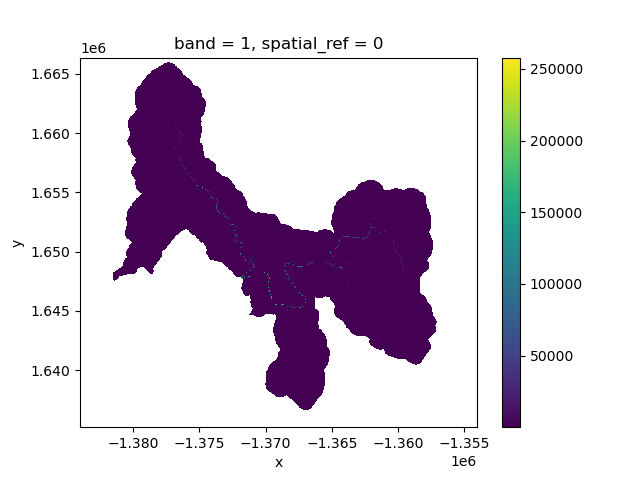

In [123]:
%matplotlib widget
fac_taudem.plot()

## Convert the downstream basin FDR to TauDEM format

Converted the D8 Flow Direction Raster (FDR) from esri format to taudem


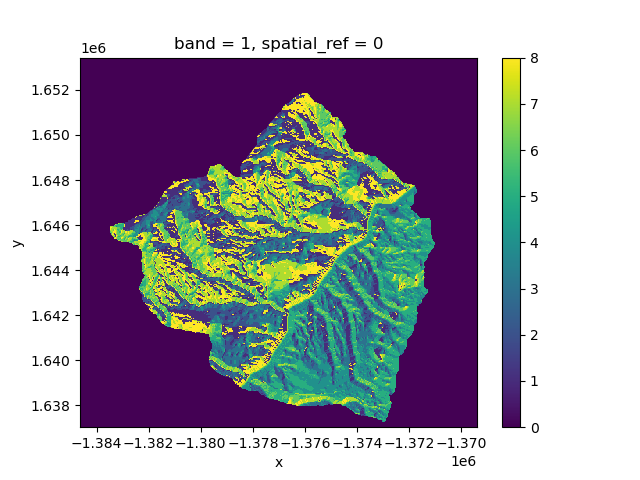

In [124]:
%matplotlib widget
ds_fdr_taudem = tools.convert_fdr_formats(
    ds_fdr,
    out_format='taudem',
    )
ds_fdr_taudem.plot()

## Cascade upstream accumulation to the downstream basin

In [125]:
%%time
ds_accumulate = terrainengine.taudem_engine.accumulate_flow(
    ds_fdr_taudem,
    upstream_pour_points=fac_pour_point_values,
)

CPU times: total: 188 ms
Wall time: 457 ms


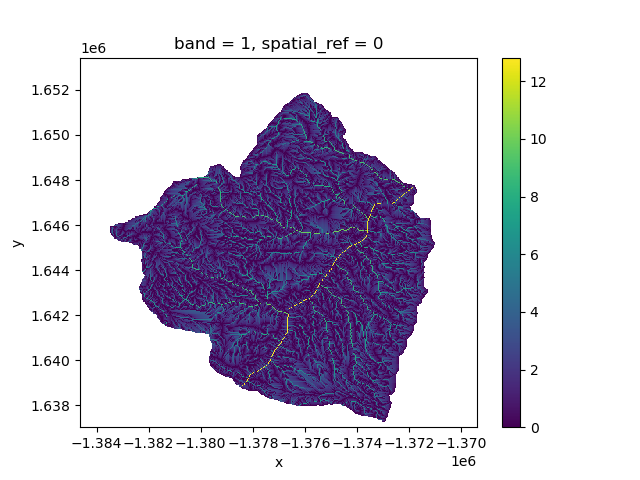

In [156]:
%matplotlib widget
np.log(ds_accumulate).plot()

In [127]:
# test that the pour point is updated
updated_coords = utilities._find_downstream_cell(
    ds_fdr_taudem,
    fac_pour_point_values['pour_point_coords'][0])
us_val = fac_pour_point_values['pour_point_values'][0][0]
print(f'Cascaded amoutn from upstream: {us_val}')
ds_val = utilities._query_point(
    ds_accumulate,
    updated_coords,
    )[-1]
print(f'Value of cell downstream from the upstream pour point: {ds_val}')
print('If the numbers above are not very simular there is likely an issue!')

Cascaded amoutn from upstream: 257922.0
Value of cell downstream from the upstream pour point: 257928.0
If the numbers above are not very simular there is likely an issue!


## Cascade upstream precipitation to the downstream basin
This tests the multi-dimensional cascade functionality.

In [129]:
precip_pour_point_values = tools.get_pour_point_values(
    fac_pour_point,
    daymet_multi_accum_taudem,
    )
display(precip_pour_point_values)

{'pour_point_ids': ['upstream_fac'],
 'pour_point_coords': [(-1371809.9999999995, 1647749.9999999963)],
 'pour_point_values': [[1601968.25,
   1713891.75,
   6650215.5,
   1551558.625,
   0.0,
   677839.625,
   9266240.0,
   3756741.0,
   4090011.0,
   9710814.0,
   0.0,
   4939786.0]]}

### Pull in downstream precipitation and align with the downstream FDR

In [133]:
ds_bounding_box = list(tools.reproject_raster(ds_fdr_taudem, us_basin_shp).rio.bounds())
ds_bounding_box

[-111.75476548961305,
 36.745278173879214,
 -111.55403498022008,
 36.91202922400191]

In [134]:
%%time
daymet_multi_ds = pydaymet.get_bygeom(ds_bounding_box,
    crs=us_basin_shp.crs.to_wkt(),
    dates=("2021-01-01", "2021-12-30"),
    variables='prcp',
    time_scale="monthly",
    )['prcp']
daymet_multi_ds

CPU times: total: 1.36 s
Wall time: 2.49 s


<xarray.DataArray 'prcp' (time: 12, y: 20, x: 19)>
dask.array<getitem, shape=(12, 20, 19), dtype=float32, chunksize=(12, 20, 19), chunktype=numpy.ndarray>
Coordinates:
  * time                     (time) datetime64[ns] 2021-01-16T12:00:00 ... 20...
  * y                        (y) float32 -523.0 -524.0 -525.0 ... -541.0 -542.0
  * x                        (x) float32 -1.003e+03 -1.002e+03 ... -986.2 -985.2
    lambert_conformal_conic  int32 0
Attributes:
    cell_methods:  area: mean time: sum within days time: sum over days
    units:         mm
    long_name:     monthly total precipitation
    _ChunkSizes:   [ 10 300 300]

In [138]:
daymet_multi_ds_aligned = tools.align_raster(daymet_multi_ds, ds_fdr_taudem)

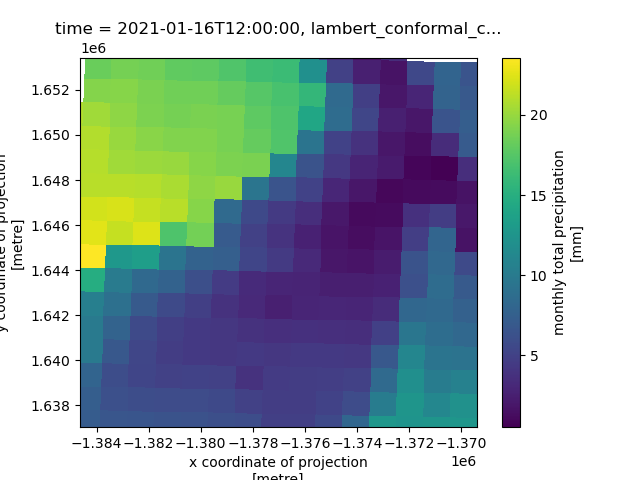

In [139]:
%matplotlib widget
daymet_multi_ds_aligned[0].plot()

### Cascade the upstream multi-dimensional precipitation downstream!

In [140]:
%%time
ds_precip_accum = terrainengine.taudem_engine.accumulate_parameter(
    ds_fdr_taudem,
    daymet_multi_ds_aligned,
    precip_pour_point_values,
    )

CPU times: total: 1.39 s
Wall time: 4.44 s


In [154]:
# verify that we updated the parameter grid
updated_coords_precip = utilities._find_downstream_cell(
    ds_fdr_taudem,
    precip_pour_point_values['pour_point_coords'][0])
us_precip_val = precip_pour_point_values['pour_point_values'][0][0]
print(f'Cascaded amount from upstream: {us_precip_val}')
ds_precip_val = utilities._query_point(
    ds_precip_accum,
    updated_coords_precip,
    )[-1]
print(f'Value of cell downstream from the upstream pour point: {ds_precip_val}')
print('If the numbers above are not very simular there is likely an issue!')

Cascaded amount from upstream: 1601968.25
Value of cell downstream from the upstream pour point: 1601975.0
If the numbers above are not very simular there is likely an issue!


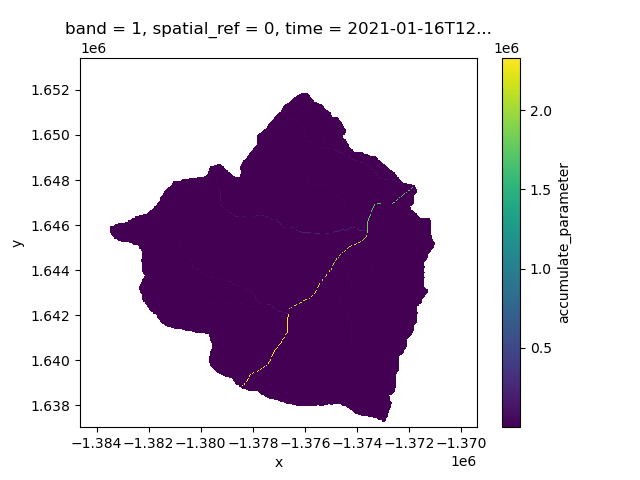

In [142]:
%matplotlib widget
ds_precip_accum[0].plot()

### Make downstream precipitation FCPG including cascaded values from upstream

In [161]:
%%time
ds_fcpg = tools.make_fcpg(
    ds_precip_accum,
    ds_accumulate,
    )

CPU times: total: 31.2 ms
Wall time: 12 ms


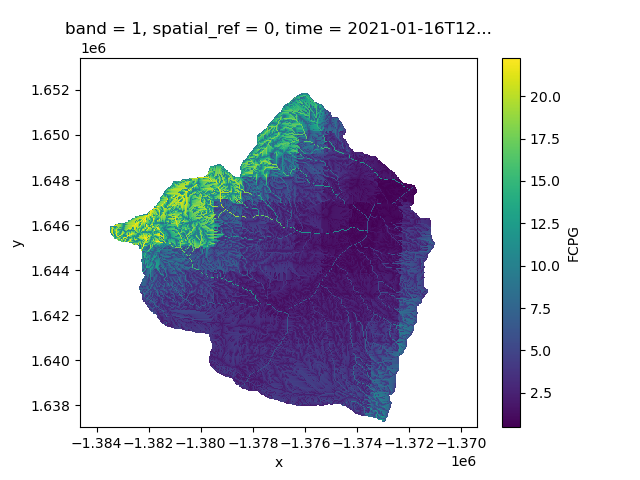

In [162]:
%matplotlib widget
ds_fcpg[0].plot()